In [2]:
from data_preprocessor import DataPreprocessor
from quantum_circuits import QuantumCircuits
from quantum_kernel_svm import QuantumSVM  # New module

# Load data
preprocessor = DataPreprocessor(n_components=2, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = preprocessor.load_and_preprocess()
print(f"Explained variance ratio (PCA): {preprocessor.get_explained_variance_ratio()}")

# Initialize circuits and get kernel functions
circuits = QuantumCircuits(wires=2)
kernel1, kernel2 = circuits.get_kernel_functions()
print(circuits.get_kernel_functions())
# Evaluate Proposal 1 (AEFM)
print("\nEvaluating AEFM (Proposal 1)...")
qsvm1 = QuantumSVM(kernel1)
results1 = qsvm1.evaluate(X_train, y_train, X_test, y_test)

# Evaluate Proposal 2 (SEFM-H)
print("Evaluating SEFM-H (Proposal 2)...")
qsvm2 = QuantumSVM(kernel2)
results2 = qsvm2.evaluate(X_train, y_train, X_test, y_test)

print(f"AEFM       - Test Accuracy: {results1['test_acc']:.3f} (CV: {results1['cv_mean']:.3f}±{results1['cv_std']:.3f})")
print(f"SEFM-H     - Test Accuracy: {results2['test_acc']:.3f} (CV: {results2['cv_mean']:.3f}±{results2['cv_std']:.3f})")

Explained variance ratio (PCA): [0.83717573 0.08612781]
(<function QuantumCircuits.get_kernel_functions.<locals>.kernel1 at 0x0000018761FBBCE0>, <function QuantumCircuits.get_kernel_functions.<locals>.kernel2 at 0x0000018761FBBC40>)

Evaluating AEFM (Proposal 1)...
Evaluating SEFM-H (Proposal 2)...
AEFM       - Test Accuracy: 0.900 (CV: 0.871±0.083)
SEFM-H     - Test Accuracy: 0.967 (CV: 0.914±0.053)


In [4]:
!pip install scipy matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 4.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/8.1 MB 4.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 3.6 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 3.8 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 3.9 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 3.9 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 3.7 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 3.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 3.7 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 3.7 MB/s  0:00:02
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------- ------------

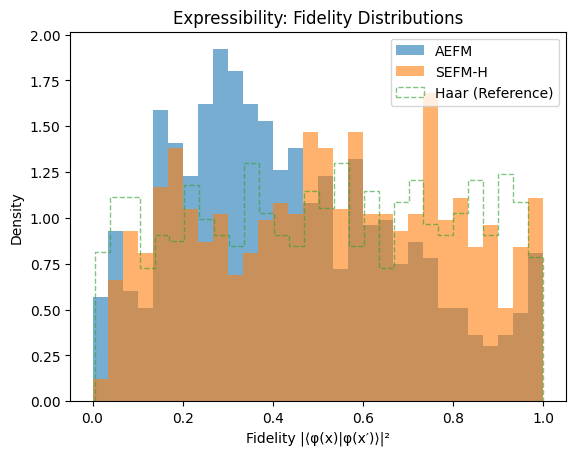

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sample_fidelities(kernel_fn, X, n_samples=1000):
    fids = []
    for _ in range(n_samples):
        i, j = np.random.choice(len(X), 2)
        fid = kernel_fn(X[i], X[j])
        fids.append(fid)
    return np.array(fids)

fids_aefm = sample_fidelities(kernel1, X_train)
fids_sefmh = sample_fidelities(kernel2, X_train)

# Haar-random reference (for 2 qubits: beta=1, alpha=1 in Beta distribution)
haar_fids = np.random.beta(1, 1, 1000)  # Simplified; exact Haar for n=2 is Beta(1,1)

plt.hist(fids_aefm, bins=30, alpha=0.6, label='AEFM', density=True)
plt.hist(fids_sefmh, bins=30, alpha=0.6, label='SEFM-H', density=True)
plt.hist(haar_fids, bins=30, alpha=0.6, label='Haar (Reference)', density=True, linestyle='--', histtype='step')
plt.xlabel('Fidelity |⟨φ(x)|φ(x′)⟩|²')
plt.ylabel('Density')
plt.legend()
plt.title('Expressibility: Fidelity Distributions')
plt.show()

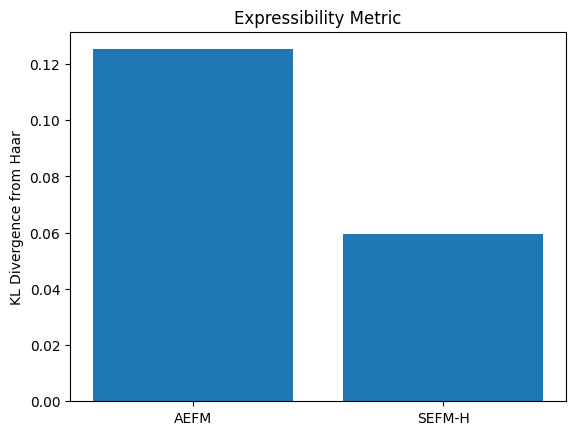

In [6]:
from scipy.stats import entropy

def kl_divergence(p, q):
    return entropy(p, q)

# Bin fidelities
bins = np.linspace(0, 1, 30)
p_aefm, _ = np.histogram(fids_aefm, bins=bins, density=True)
p_sefmh, _ = np.histogram(fids_sefmh, bins=bins, density=True)
p_haar, _ = np.histogram(haar_fids, bins=bins, density=True)

kl_aefm = kl_divergence(p_aefm + 1e-10, p_haar + 1e-10)
kl_sefmh = kl_divergence(p_sefmh + 1e-10, p_haar + 1e-10)

plt.bar(['AEFM', 'SEFM-H'], [kl_aefm, kl_sefmh])
plt.ylabel('KL Divergence from Haar')
plt.title('Expressibility Metric')
plt.show()

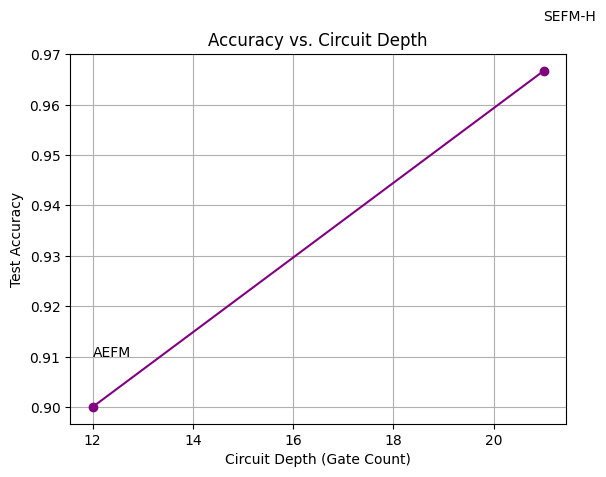

In [7]:
depths = [12, 21]  # AEFM, SEFM-H
accs = [results1['test_acc'], results2['test_acc']]

plt.plot(depths, accs, 'o-', color='purple')
plt.xlabel('Circuit Depth (Gate Count)')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs. Circuit Depth')
for i, model in enumerate(['AEFM', 'SEFM-H']):
    plt.text(depths[i], accs[i] + 0.01, model)
plt.grid(True)
plt.show()